# Parameter estimation using qualitative data

This Notebook eplains the use of qualitative data for parameter estimation, as described in [Schmiester et al. (2020)](https://link.springer.com/article/10.1007/s00285-020-01522-w) and [Schmiester et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.02.06.430039v1.abstract).

## Specification of qualitative data in the PEtab format

The qualitative data can be specified as a non-standard extension to [PEtab](https://journals.plos.org/ploscompbiol/article?rev=2&id=10.1371/journal.pcbi.1008646). Categories can be defined as observable Parameters. Datapoints can be collected into categories by assigning the same `observableParameters` in the measurement file.  pyPESTO recognizes these parameters as optimal scaling categories via the `parameterType`, `parameterGroup` and `parameterCategory` columns in the parameters file. `parameterType=qualitative_scaling` identifies the parameter as an optimal scaling parameter. The `parameterGroup` is an integer, specifying if these parameters are comparable or from different qualitative datasets, where no qualitative relation is known between them (e.g. different observables). `parameterCategory` is also an integer, which defines the category index in ascending order, i.e. `category 1 < category 2 < ...`. Both are indexed starting with 1. An example how this looks like in detail is provided in the `example_qualitative` folder.

## Import model and create pyPESTO objective

In [1]:
import pypesto
import pypesto.petab
import pypesto.optimize as optimize

import amici
import petab
import numpy as np
from pypesto.hierarchical.optimal_scaling_solver import OptimalScalingInnerSolver
import pypesto.logging
import logging

In [2]:
petab_folder = './example_qualitative/'
yaml_file = 'example_qualitative.yaml'

petab_problem = petab.Problem.from_yaml(petab_folder + yaml_file)

importer = pypesto.petab.PetabImporter(petab_problem)

model = importer.create_model()

In [3]:
# To enable the optimal scaling approach for qualitative data, set qualitative=True, when creating the objective

objective = importer.create_objective(qualitative=True)
problem = importer.create_problem(objective)

engine = pypesto.engine.SingleCoreEngine()

## Evaluation of the objective function

After creating the pyPESTO optimal scaling objective function, it can be called with a parameter vector as input. It will output either the objective function value or additionally the gradient, if it is required.

In [4]:
# Evaluation of the objective function without gradients
print(objective(petab_problem.x_nominal_scaled))

# The sensi_orders input can be used to specify, that also gradients need to be computed
print(objective(petab_problem.x_nominal_scaled, sensi_orders=(0,1)))

0.010643646572165256
(0.010643646546700499, array([ 0.        ,  0.        ,  0.02205115, -0.0266729 ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ]))


## Run optimization using the optimal scaling approach

We test parameter estimation using the Scipy optimizer Powell (gradient-free) and L-BFGS-B (gradient-based). In this example we use multi-start optimization with 10 starts.

In [5]:
# create a pyPESTO optimizer using the gradient-free Powell algorithm
optimizer_gf = optimize.ScipyOptimizer(method='powell',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

# create a pyPESTO optimizer using the gradient-based L-BFGS-B algorithm
optimizer_gb = optimize.ScipyOptimizer(method='L-BFGS-B',
                                   options={'disp': True, 'maxiter': 500, 'maxfev': 500, 'fatol': 1e-10})

n_starts = 10

The optimal scaling problem can be solved in different ways, which can be chosen in the pyPESTO problem. The options are:
- method: `standard` / `reduced`
- reparameterized: `True` / `False`
- intervalConstraints: `max` / `max-min`
- minGap: Any float value

It is recommended to use the reduced method with reparameterization and `max` interval constraints as it is the most efficient and robust choice, which we will also use here.

When no options are provided, the default is the reduced and reparameterized formulation with max as interval constraint and `minGap=1e-10`.

### Run optimization with the gradient-free optimizer

In [6]:
# Set the options for solving the optimal scaling problem
problem.objective.calculator.inner_solver = OptimalScalingInnerSolver(options={'method': 'reduced',
                                                                               'reparameterized': True,
                                                                               'intervalConstraints': 'max',
                                                                               'minGap': 1e-10})
# Run optimization with the gradient-free optimizer
res_reduced_reparameterized = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gf, engine=engine)

Function values from history and optimizer do not match: 0.0005773458037304112, 0.0005773672461441257
Parameters obtained from history and optimizer do not match: [4.99999872 3.0899277 ], [4.99991541 3.08968894]


Optimization terminated successfully.
         Current function value: 0.000577
         Iterations: 5
         Function evaluations: 252


Function values from history and optimizer do not match: 0.0005707657240471128, 0.0005735454593197392
Parameters obtained from history and optimizer do not match: [6.72026356 4.84242439], [4.99999271 3.14594538]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 7
         Function evaluations: 475


Parameters obtained from history and optimizer do not match: [5.0000488  3.14580304], [4.99999789 3.14610299]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 3
         Function evaluations: 223


Function values from history and optimizer do not match: 0.000570633486125277, 0.0005735454371788714
Parameters obtained from history and optimizer do not match: [5.65054796 3.79711465], [4.99999843 3.14602585]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 5
         Function evaluations: 376
Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 4
         Function evaluations: 335


Function values from history and optimizer do not match: 0.0005703349519154095, 0.0005735455244334158
Parameters obtained from history and optimizer do not match: [7.01808403 5.14896176], [4.99998873 3.14601979]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 7
         Function evaluations: 431


Function values from history and optimizer do not match: 0.0005700516465445632, 0.0005735454403819339
Parameters obtained from history and optimizer do not match: [6.57394304 4.72076099], [4.9999987  3.14606696]


Optimization terminated successfully.
         Current function value: 0.000574
         Iterations: 5
         Function evaluations: 253


### Run optimization with the gradient-based optimizer

In [7]:
res_gb = optimize.minimize(problem, n_starts=n_starts, optimizer=optimizer_gb, engine=engine)

### Compare results

Reduced formulation leads to improved computation times

In [8]:
time_reduced_reparameterized = res_reduced_reparameterized.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-free optimizer: {np.mean(time_reduced_reparameterized)}")

time_gb = res_gb.optimize_result.get_for_key('time')
print(f"Mean computation time for gradient-based optimizer: {np.mean(time_gb)}")


Mean computation time for gradient-free optimizer: 7.827827215194702
Mean computation time for gradient-based optimizer: 4.345226287841797


Both optimizers yield the same final objective function values

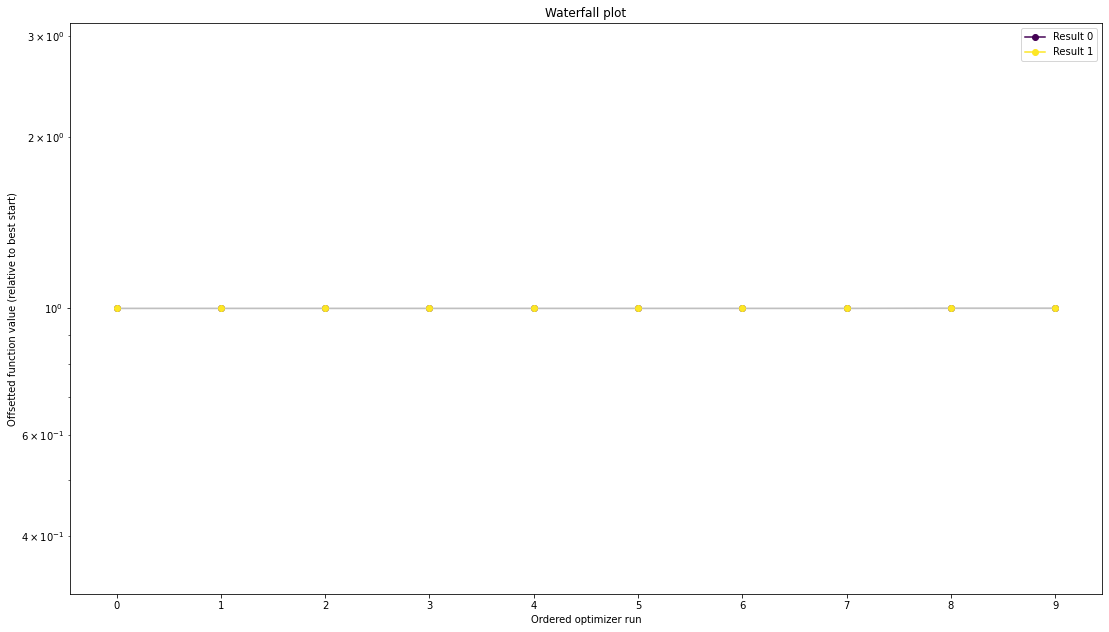

In [9]:
from pypesto.visualize import waterfall

waterfall([res_reduced_reparameterized, res_gb])